In [1]:
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate, ndimage, signal, stats, fftpack
import bombcell as bc

✅ ipywidgets available - interactive GUI ready


#### Change this path to point to your code

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind
# from tbd_eeg.tbd_eeg.data_analysis.eeg_preprocessing import qualitycheck_trials

In [5]:
%matplotlib ipympl

In [6]:
plotdir = r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\SWD_examples"

#### Functions

In [7]:
## Using bombcell classification for striatum (https://github.com/Julie-Fabre/bombcell/blob/main/py_bombcell/bombcell/classification.py)
def get_put_cell_types(unit_info):
    ## bombcell classification parameters ##
    templateDuration_CP_threshold = 400  # microseconds
    postSpikeSup_CP_threshold = 40       # milliseconds  
    propISI_CP_threshold = 0.1
    templateDuration_Ctx_threshold = 400  # microseconds
    templateDuration_TH_threshold = 325  # microseconds

    put_cell_type = []
    for unitind, unitrow in unit_info.iterrows():
        if unitrow.parent_region == 'STR':
            if (np.isnan(unitrow.spike_duration) or # If any required property is missing, assign Unknown
                np.isnan(unitrow.bc_ps_supp_ms) or 
                np.isnan(unitrow.bc_proplongisi)):
                put_cell_type.append('unknown')
                continue
            if (unitrow.spike_duration * 1E3 > templateDuration_CP_threshold and # MSN: wide waveform AND short post-spike suppression
                unitrow.bc_ps_supp_ms < postSpikeSup_CP_threshold):
                put_cell_type.append('MSN')
            elif (unitrow.spike_duration * 1E3 <= templateDuration_CP_threshold and # FSI: narrow waveform AND low proportion of long ISIs
                  unitrow.bc_proplongisi <= propISI_CP_threshold):
                put_cell_type.append('FSI')
            elif (unitrow.spike_duration * 1E3 > templateDuration_CP_threshold and # TAN: wide waveform AND long post-spike suppression
                  unitrow.bc_ps_supp_ms >= postSpikeSup_CP_threshold):
                put_cell_type.append('TAN')
            elif (unitrow.spike_duration * 1E3 <= templateDuration_CP_threshold and # UIN: narrow waveform AND high proportion of long ISIs
                  unitrow.bc_proplongisi > propISI_CP_threshold):
                put_cell_type.append('UIN')
            else: # Should not reach here with valid data
                put_cell_type.append('unknown')
        elif unitrow.parent_region in ['MO', 'SS', 'VIS', 'PL', 'ACA', 'ILA', 'ORB', 'RSP', 'HIP']:
            if unitrow.spike_duration * 1E3 > templateDuration_Ctx_threshold:
                put_cell_type.append('RS')
            else:
                put_cell_type.append('FS')
        elif unitrow.parent_region == 'TH':
            if unitrow.spike_duration * 1E3 < templateDuration_TH_threshold:
                put_cell_type.append('pRT')
            else:
                put_cell_type.append('TC')
        else:
            put_cell_type.append('unknown')
    unit_info['cell_type'] = put_cell_type
    return unit_info

### Load experiment

In [8]:
data_dir = Path(r"E:\GAT1_EEG_pilot")
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\subject_metadata.csv")
all_subexp = pd.read_csv(subject_csv)
all_subexp.head(10)

,genotype,mouse,sex,exp_folder,sweep_states,bad_chs,notes
0,GAT1-KO,mouse645606,M,signal_test_2022-11-18_14-49-19,awake,none,NaN
1,GAT1-KO,mouse645606,M,spontEEG1_2022-11-22_17-12-47,awake,none,NaN
2,GAT1-KO,mouse645606,M,EEGNPXspont_estim_2022-12-20_12-26-39,awake,none,NaN
3,GAT1-KO,mouse644565,F,signal_test_2022-11-30_15-41-47,awake,none,NaN
4,GAT1-KO,mouse644565,F,spontEEG1_2022-12-07_16-07-14,awake,none,NaN
5,GAT1-KO,mouse644565,F,EEGNPXspont_estim_2022-12-22_10-36-08,awake,none,NaN
6,GAT1-KO,mouse672785,M,visual_2023-06-27_13-19-27,awake,none,NaN
7,GAT1-KO,mouse672785,M,EEGNPXspont_estim_2023-07-05_12-39-59,awake,all,EEG has low amplitude signals and all chs look...
8,GAT1-KO,mouse672789,F,visual_2023-06-28_13-08-49,awake,none,NaN
9,GAT1-KO,mouse672789,F,EEGNPXspont_estim_2023-07-13_13-28-01,awake,none,NaN


In [9]:
choose_sub = 5
exprow = all_subexp.iloc[choose_sub]
print(exprow)

genotype                                      GAT1-KO
mouse                                     mouse644565
sex                                                 F
exp_folder      EEGNPXspont_estim_2022-12-22_10-36-08
sweep_states                                    awake
bad_chs                                          none
notes                                             NaN
Name: 5, dtype: object


In [10]:
data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [11]:
plotsavedir = os.path.join(plotdir, 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


### Load EEG data

In [12]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_data = eeg_data * 1E-3 # convert to mV
eeg_chs = np.arange(0, eeg_data.shape[1])

bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [13]:
print(eeg_ts[0])
print(eeg_ts[-1])

29.28925969205335
4379.753079310185


In [14]:
bpb, bpa = signal.butter(3, np.array([0.5, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_data, axis=0)

### Load other data

#### Load SWDs

In [15]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
if os.path.exists(auto_annot_file):
    print('Whoope there it is')
    autoSWD_df = pd.read_pickle(auto_annot_file)
else:
    print('Oops, you forgot to run the auto annotation notebook')

Whoope there it is


In [16]:
autoSWD_df.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,30.672867,32.045674,1.372807,10,"[30.67286684096313, 30.913668085150377, 31.054..."
1,34.457286,36.512097,2.054811,14,"[34.457286394543786, 34.58928707657334, 34.725..."
2,37.027700,39.314111,2.286412,14,"[37.02769967551929, 37.202100576625014, 37.513..."
3,40.722119,42.564528,1.842410,9,"[40.722118764079795, 40.86451949984502, 41.181..."
4,44.878540,47.866956,2.988415,18,"[44.87854023974374, 45.03494104784542, 45.1637..."


Print some stats

In [17]:
print('Number of SWDs in {:d} min recording: {:d} events'.format(int((eeg_ts[-1]-eeg_ts[0])/60), len(autoSWD_df)))
print('Average SWD duration: {:.1f} s [min={:.1f}, max={:.1f}]'.format(
    np.mean(autoSWD_df['duration'].values), np.min(autoSWD_df['duration'].values), np.max(autoSWD_df['duration'].values)))
print('Total time spent in SWD: {:.1f} min'.format(np.sum(autoSWD_df['duration'].values)/60))

Number of SWDs in 72 min recording: 1049 events
Average SWD duration: 1.4 s [min=0.5, max=6.4]
Total time spent in SWD: 24.3 min


#### Load stim log

In [18]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    # print(stim_log.head())
else:
    stim_log = None
    print('No stim log found.')

#### Load pupil

In [19]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
  
    pupilts = pupildf.sync_time.values
    pupilR = pupildf.Largest_Radius.values
    ## smooth pupil radius, then normalize ##
    sm_pupil = np.zeros_like(pupilR)
    k = 5 # filter window is actually k*2+1
    for i in range(k, len(pupilR)-k-1):
        sm_pupil[i] = np.mean(pupilR[i-k:i+k]) # each point is the average of k surrounding points
    sm_pupil[:k] = pupilR[:k]
    sm_pupil[-k-1:] = pupilR[-k-1:]
    print('{:d}% of frames have good pupil measurements'.format(int((1 - (np.sum(np.isnan(pupilR)) / len(pupilR))) * 100)))
else:
    print('No local Pupileye*.csv file. Check server.')

99% of frames have good pupil measurements


#### Load running

In [20]:
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
raw_running_file = os.path.join(exp.data_folder, 'raw_running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    print('Loading saved speed file...')
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)
else:
    print('Loading and saving running speed...')
    speed, raw_speed, speedts = exp.load_running()
    np.save(running_file, speed, allow_pickle=False)
    np.save(raw_running_file, raw_speed, allow_pickle=False)
    np.save(running_ts_file, speedts, allow_pickle=False)

Loading saved speed file...


### Load units and spikes

In [21]:
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region
0,B0,probeB,0,3680,0.370854,PO,269,162,173,5.108656,0.99,0.788976,0.500000,22225,TH
1,B1,probeB,0,3680,0.398325,PO,269,162,173,11.458331,0.99,0.160769,0.001680,49849,TH
2,B2,probeB,0,3680,0.453266,PO,269,162,173,1.618910,0.99,1.446394,0.500000,7043,TH
3,B3,probeB,1,3680,0.384590,PO,269,162,173,4.637902,0.99,0.100133,0.000948,20177,TH
4,B4,probeB,1,3680,0.494472,PO,269,162,173,6.090622,0.99,0.048773,0.085176,26497,TH


In [22]:
for pregi in np.unique(unit_info['parent_region'].values):
    pudf = unit_info[unit_info['parent_region'] == pregi]
    print('{}: {:d} units'.format(pregi, len(pudf)))

HIP: 160 units
MO: 291 units
PAL: 17 units
PTLp: 28 units
SS: 207 units
STR: 554 units
TH: 316 units


Get some spiking info and cell types (bombcell)

In [23]:
## Get spontaneous times
deltat = 1. # window size, s
btime = stim_log.onset.values[0]
spontbins = np.arange(eeg_ts[0], btime, deltat)
spontSWD = autoSWD_df[(autoSWD_df['onset'] > eeg_ts[0]) & (autoSWD_df['offset'] < btime)]

## Get the mean firing rate for all states and add it to the unit_info df ##
spontFR = []
spontBR = []
spont_burstratio = []
spontFR_out = []
spontFR_in = []
spontBR_out = []
spontBR_in = []
bc_postspike_supp_ms = np.zeros((len(unit_info))) * np.nan
bc_prop_long_isi = np.zeros((len(unit_info))) * np.nan
for unitind, unitrow in unit_info.iterrows():
    uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
    ubursts = all_unit_all_spikes[unitrow.unit_id]['bursts']
    ubcs = all_unit_all_spikes[unitrow.unit_id]['burst_counts']
    ## Spontaneous ##
    spikecounts, edges = np.histogram(uspikes, spontbins)
    spontFR.append(np.mean(spikecounts / deltat))
    burstcounts, edges = np.histogram(ubursts, spontbins)
    spontBR.append(np.mean(burstcounts / deltat))
    ## Burst ratio ##
    spont_burstratio.append(
        np.sum(ubcs[np.nonzero((ubursts >= eeg_ts[0]) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= eeg_ts[0]) & (uspikes <= btime))[0]))
    ## bombcell spiking properties ##
    ephys_param = bc.get_ephys_parameters(ephys_path=os.path.dirname(exp.ephys_params[unitrow.probe]['spike_clusters']))
    acg_props = bc.compute_acg_properties(uspikes, ephys_param)
    bc_postspike_supp_ms[unitind] = acg_props.get('post_spike_suppression_ms', np.nan)
    isi_props = bc.compute_isi_properties(uspikes, ephys_param)
    bc_prop_long_isi[unitind] = isi_props.get('prop_long_isi', np.nan)
    
    ## firing rate between SWDs ##
    in_FR = []
    out_FR = []
    in_BR = []
    out_BR = []
    for j in range(len(spontSWD)-1):
        SWDeventj = spontSWD.iloc[j]
        SWDeventjj = spontSWD.iloc[j+1]
        ## within SWD ##
        SWDspikes = uspikes[np.nonzero((uspikes >= SWDeventj.onset) & (uspikes <= SWDeventj.offset))[0]]
        SWDbursts = ubursts[np.nonzero((ubursts >= SWDeventj.onset) & (ubursts <= SWDeventj.offset))[0]]
        in_FR.append(len(SWDspikes) / (SWDeventj.offset - SWDeventj.onset))
        in_BR.append(len(SWDbursts) / (SWDeventj.offset - SWDeventj.onset))
        ## out of SWD ##
        nonSWDspikes = uspikes[np.nonzero((uspikes >= SWDeventj.offset) & (uspikes <= SWDeventjj.onset))[0]]
        nonSWDbursts = ubursts[np.nonzero((ubursts >= SWDeventj.offset) & (ubursts <= SWDeventjj.onset))[0]]
        out_FR.append(len(nonSWDspikes) / (SWDeventjj.onset - SWDeventj.offset))
        out_BR.append(len(nonSWDbursts) / (SWDeventjj.onset - SWDeventj.offset))
    spontFR_out.append(np.mean(out_FR))
    spontFR_in.append(np.mean(in_FR))
    spontBR_out.append(np.mean(out_BR))
    spontBR_in.append(np.mean(in_BR))
            
unit_info['spont_FR'] = spontFR
unit_info['spont_BR'] = spontBR
unit_info['burst_ratio'] = spont_burstratio
unit_info['spont_FR_outSWD'] = spontFR_out
unit_info['spont_FR_inSWD'] = spontFR_in
unit_info['spont_BR_outSWD'] = spontBR_out
unit_info['spont_BR_inSWD'] = spontBR_in
unit_info['bc_ps_supp_ms'] = bc_postspike_supp_ms
unit_info['bc_proplongisi'] = bc_prop_long_isi

#### Apply cell type classification ####
unit_info = get_put_cell_types(unit_info)

In [24]:
unit_info.head(20)

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,spont_FR,spont_BR,burst_ratio,spont_FR_outSWD,spont_FR_inSWD,spont_BR_outSWD,spont_BR_inSWD,bc_ps_supp_ms,bc_proplongisi,cell_type
0,B0,probeB,0,3680,0.370854,PO,269,162,173,5.108656,0.99,0.788976,0.500000,22225,TH,5.445430,0.137108,0.046659,3.509451,2.189787,0.112421,0.137959,1.0,0.014264,TC
1,B1,probeB,0,3680,0.398325,PO,269,162,173,11.458331,0.99,0.160769,0.001680,49849,TH,11.849932,0.650409,0.195954,9.928958,7.523727,0.786356,0.887572,1.0,0.000883,TC
2,B2,probeB,0,3680,0.453266,PO,269,162,173,1.618910,0.99,1.446394,0.500000,7043,TH,1.617667,0.074011,0.089817,1.186025,0.846953,0.079844,0.083051,1.0,0.072991,TC
3,B3,probeB,1,3680,0.384590,PO,269,162,173,4.637902,0.99,0.100133,0.000948,20177,TH,4.723397,0.383697,0.284621,4.123566,3.392944,0.441404,0.513148,1.0,0.018834,TC
4,B4,probeB,1,3680,0.494472,PO,269,162,173,6.090622,0.99,0.048773,0.085176,26497,TH,6.471692,0.707367,0.287678,5.239866,5.527146,0.756339,1.014678,1.0,0.002114,TC
5,B5,probeB,1,3680,0.343384,PO,269,162,173,4.348966,0.99,0.195873,0.079074,18920,TH,4.570259,0.295020,0.171827,3.263440,2.493790,0.331509,0.425779,1.0,0.018341,TC
6,B6,probeB,5,3640,0.357119,PO,269,160,173,4.956259,0.99,0.056117,0.001053,21562,TH,5.249318,0.437926,0.301806,3.907488,3.290866,0.458949,0.636743,1.0,0.015352,TC
7,B7,probeB,1,3680,0.412060,PO,269,162,173,1.392956,0.99,1.287662,0.451247,6060,TH,0.875171,0.022169,0.050273,0.481550,0.301706,0.022201,0.010653,1.0,0.068823,TC
8,B8,probeB,2,3660,0.384590,PO,269,161,173,7.798258,0.99,0.461851,0.001503,33926,TH,8.098568,0.618690,0.259074,6.298265,5.253728,0.717780,0.882552,1.0,0.005306,TC
9,B9,probeB,2,3660,0.467002,PO,269,161,173,2.650295,0.99,0.171719,0.481475,11530,TH,3.087995,0.097203,0.062182,2.295458,1.654484,0.109901,0.133426,1.0,0.044843,TC


### Plot an SWD event

In [25]:
plot_regions = ['TH', 'HIP', 'STR', 'VIS', 'SS', 'MO'] # 'VIS'
SWDdelta = 5.0 # time around SWD to plot, s

In [26]:
autoSWD_df[30:50]

,onset,offset,duration,spike_count,SWD_spike_times
30,157.396320,157.992319,0.595999,4,"[157.3963196992889, 157.68071942376625, 157.83..."
31,158.527119,160.510317,1.983198,11,"[158.527118603786, 158.67591845963068, 158.862..."
32,161.948715,163.265514,1.316799,8,"[161.94871528898878, 162.27911496890198, 162.4..."
33,163.740714,164.949512,1.208799,8,"[163.74071355292475, 163.8815134165197, 164.02..."
34,166.733911,169.981108,3.247197,15,"[166.73391065315533, 166.94831044544767, 167.2..."
35,174.153903,175.209502,1.055599,7,"[174.15390346476525, 174.30750331595976, 174.5..."
36,175.964702,176.898301,0.933599,7,"[175.96470171048807, 176.13470154579448, 176.3..."
37,177.307500,178.049900,0.742399,5,"[177.3075004096026, 177.56910015616825, 177.58..."
38,178.901499,179.865898,0.964399,5,"[178.90149886535815, 179.0490987223654, 179.39..."
39,181.861496,182.682695,0.821199,6,"[181.8614959977524, 182.03949582530856, 182.20..."


In [36]:
SWDind = 2
SWDevent = autoSWD_df.iloc[SWDind]
print(SWDevent.duration)

2.171591584685345


Plot EEG + all region raster

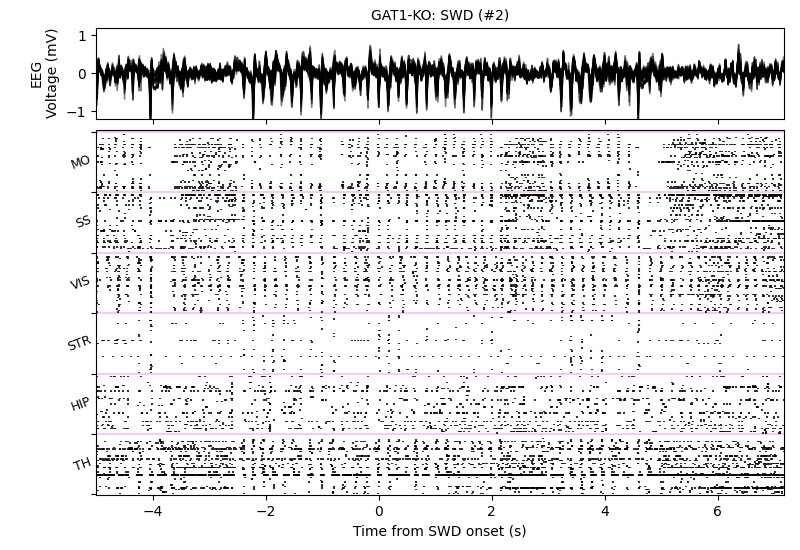

In [38]:
## Plot one half-slide ##
timezero = SWDevent.onset
pwin = [SWDevent.onset - SWDdelta, SWDevent.offset + SWDdelta]
# timezero = 100.0
# pwin = np.array([100.0 - deltat, 102.1 + deltat])
umax = 40

fig = plt.figure(figsize=(8, 5.5)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.12, right=0.98, top=0.95, bottom=0.1, hspace=0.05, height_ratios=[1,4])
EEGax = fig.add_subplot(gs[0])
rasterax = fig.add_subplot(gs[1])

## Plot EEG ##
eeginds = np.nonzero((eeg_ts > pwin[0]) & (eeg_ts < pwin[1]))[0]
# EEGax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
EEGax.plot(eeg_ts[eeginds] - timezero, filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
EEGax.set_xlim(pwin - timezero)
EEGax.set_xticklabels([])
EEGax.set_ylim([-1.2, 1.2])
# EEGax.set_ylim([-0.25, 0.25])
EEGax.set_ylabel('EEG\nVoltage (mV)')
EEGax.set_title('GAT1-KO: SWD (#{:d})'.format(SWDind))
# EEGax.set_title('Wild type (not litter mate): spontaneous activity')

## Plot raster ##
# rasterax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
last_ind = 0
regb = [last_ind]
for ii, pregi in enumerate(plot_regions):
    regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
    if len(regdf) > umax:
        punitinds = np.random.choice(range(len(regdf)), size=umax, replace=False)
    else:
        punitinds = range(len(regdf))
    for indi in punitinds:
        urow = regdf.iloc[indi]
        uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
        SWDspikes = uspiketimes[
            np.nonzero((uspiketimes > pwin[0]) & (uspiketimes < pwin[1]))[0]
        ]
        rasterax.eventplot(SWDspikes - timezero, lineoffsets=last_ind, linelengths=1.0, color='black', alpha=0.8)
        last_ind += 1
    rasterax.annotate(
        '{}'.format(pregi), xy=(-(SWDdelta+0.05), last_ind - len(punitinds)/2), xycoords='data',
        annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
    )
    last_ind += 2
    regb.append(last_ind - 1)
    rasterax.axhline(last_ind - 1, color='m', alpha=0.2)

rasterax.set_ylim(-1, last_ind)
rasterax.set_xlim(pwin - timezero)
rasterax.set_xlabel('Time from SWD onset (s)')
rasterax.set_yticks(regb)
rasterax.set_yticklabels([])

### SAVE ###
fig_name = 'SWD_EEG_NP_example{:d}.png'.format(SWDind)
# fig_name = 'spont_EEG_NPX_example.png'
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

In [40]:
print(plotsavedir)

C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\SWD_examples\mouse672789


### Plot multiple SWD events

In [28]:
print(len(autoSWD_df))
print(len(spontSWD))

1049
697


In [29]:
# autoSWD_df[(autoSWD_df['duration'] > 1.8) & (autoSWD_df['duration'] < 2.2)][:10]
spontSWD[(spontSWD['duration'] > 0.75) & (spontSWD['duration'] < 5.0)][0:50]

,onset,offset,duration,spike_count,SWD_spike_times
0,30.672867,32.045674,1.372807,10,"[30.67286684096313, 30.913668085150377, 31.054..."
1,34.457286,36.512097,2.054811,14,"[34.457286394543786, 34.58928707657334, 34.725..."
2,37.027700,39.314111,2.286412,14,"[37.02769967551929, 37.202100576625014, 37.513..."
3,40.722119,42.564528,1.842410,9,"[40.722118764079795, 40.86451949984502, 41.181..."
4,44.878540,47.866956,2.988415,18,"[44.87854023974374, 45.03494104784542, 45.1637..."
5,49.326563,51.961777,2.635214,16,"[49.32656322207298, 49.61856473080502, 49.7637..."
7,56.741402,59.826617,3.085216,18,"[56.741401533533136, 56.931802517309094, 57.08..."
8,62.139429,63.128235,0.988805,6,"[62.139429424408405, 62.30223026557819, 62.623..."
9,63.846238,66.029850,2.183611,13,"[63.84623824325722, 64.17103992146328, 64.3626..."
10,67.486257,69.100265,1.614008,13,"[67.48625705073886, 67.61905773690194, 67.7618..."


In [30]:
# plot_regions = ['other-TH', 'SM-TH', 'RT-TH', 'SS']
SWDdelta = 1.0 # time around SWD to plot, s
SWDinds = [4, 12, 16, 21]

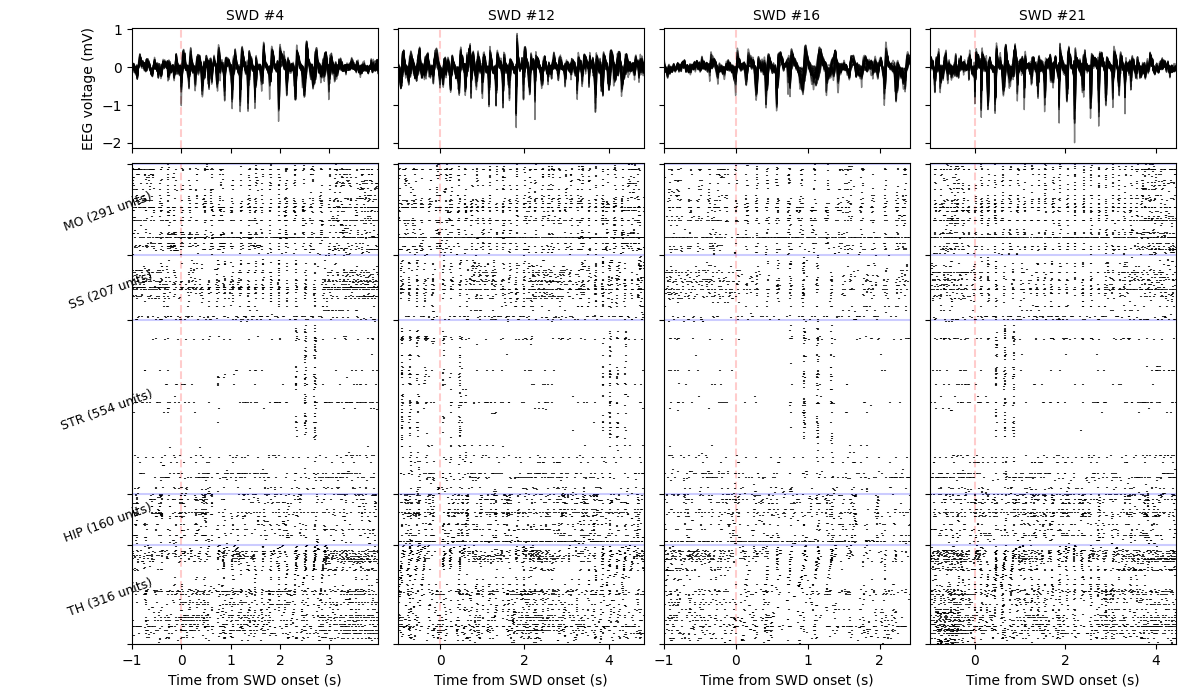

In [43]:
fig = plt.figure(figsize=(12, 7)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.11, right=0.98, top=0.96, bottom=0.08, hspace=0.05, height_ratios=[1,4])
EEGaxs = gs[0].subgridspec(ncols=len(SWDinds), nrows=1, wspace=0.08).subplots(sharey=True)
rasteraxs = gs[1].subgridspec(ncols=len(SWDinds), nrows=1, wspace=0.08).subplots(sharey=True)

for coli, SWDind in enumerate(SWDinds):
    SWDevent = autoSWD_df.iloc[SWDind]
    timezero = SWDevent.onset
    plotwin = [SWDevent.onset - SWDdelta, SWDevent.offset + SWDdelta]
    
    ## Plot EEG ##
    eeginds = np.nonzero((eeg_ts > plotwin[0]) & (eeg_ts < plotwin[1]))[0]
    EEGaxs[coli].axvline(0, color='r', linestyle='dashed', alpha=0.2)
    EEGaxs[coli].plot(eeg_ts[eeginds] - timezero, filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
    EEGaxs[coli].set_xlim(plotwin - timezero)
    EEGaxs[coli].set_xticklabels([])
    EEGaxs[coli].set_title('SWD #{:d}'.format(SWDind))
    
    ## Plot raster ##
    rasteraxs[coli].axvline(0, color='r', linestyle='dashed', alpha=0.2)
    last_ind = 0
    regb = [last_ind]
    for ii, pregi in enumerate(plot_regions):
        regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
        for indi, urow in regdf.iterrows():
            uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
            SWDspikes = uspiketimes[
                np.nonzero((uspiketimes > plotwin[0]) & (uspiketimes < plotwin[1]))[0]
            ]
            rasteraxs[coli].eventplot(SWDspikes - timezero, lineoffsets=indi + last_ind, linelengths=1.0, color='black', alpha=0.8)
        if coli == 0:
            rasteraxs[coli].annotate(
                '{} ({:d} units)'.format(pregi, len(regdf)), xy=(-0.55, last_ind + indi/2 - 10), xycoords='data',
                annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
            )
        last_ind += indi + 2
        regb.append(last_ind - 1)
        rasteraxs[coli].axhline(last_ind - 1, color='b', alpha=0.2)

    rasteraxs[coli].set_ylim(-1, last_ind)
    rasteraxs[coli].set_xlim(plotwin - timezero)
    rasteraxs[coli].set_xlabel('Time from SWD onset (s)')
    rasteraxs[coli].set_yticks(regb)
    rasteraxs[coli].set_yticklabels([])

EEGaxs[0].set_ylabel('EEG voltage (mV)')

### SAVE ###
fig_name = 'multiSWD_EEG_NPX_example.png'
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

### Plot EEG and population firing rates

In [63]:
# plot_regions = {
#     'parent_region': {'MO': 'seagreen', 'SS': 'turquoise', 'VIS': 'dodgerblue', 'HIP': 'indianred', 'TH': 'darkorange'},
#     'region': {'CP': 'indigo'}
# }
plot_regions = {
    'parent_region': {'MO': 'seagreen', 'SS': 'turquoise', 'VIS': 'dodgerblue'},
}

In [75]:
time_bin = 0.002 # size of time bins (s)
start_time = 180.0 # eeg_ts[0]
win_size = 100.0 # length of time to plot (s)
timewin = [start_time, start_time + win_size]
spike_bins = np.arange(timewin[0], timewin[1], time_bin)

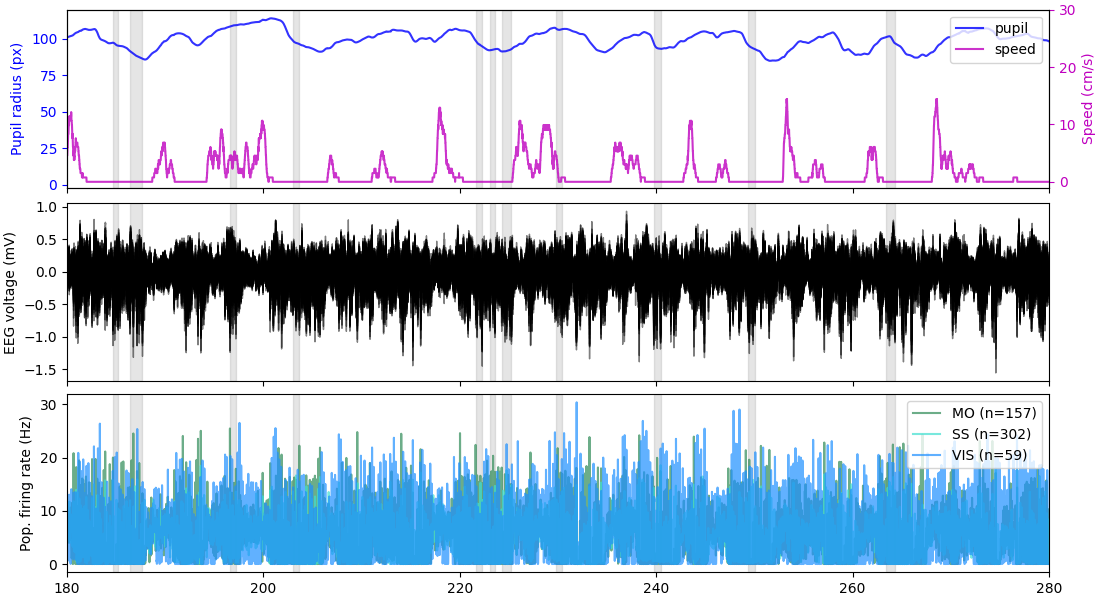

In [65]:
fig, axs = plt.subplots(3, 1, figsize=(11, 6), constrained_layout=True, sharex=True)

legenditems = []
## Pupil ##
pupinds = np.nonzero((pupilts > timewin[0]) & (pupilts < timewin[1]))[0]
pup, = axs[0].plot(pupilts[pupinds], sm_pupil[pupinds], color='b', alpha=0.8, label='pupil')
legenditems.append(pup)
axs[0].set_xlim(timewin)
axs[0].set_ylim([-2, 120])
axs[0].set_ylabel('Pupil radius (px)', color='b')
axs[0].tick_params(axis='y', colors='b')

## Running ##
runax = axs[0].twinx()
runinds = np.nonzero((speedts > timewin[0]) & (speedts < timewin[1]))[0]
run, = runax.plot(speedts[runinds], speed[runinds], color='m', alpha=0.8, label='speed')
legenditems.append(run)
runax.set_ylabel('Speed (cm/s)', color='m')
runax.tick_params(axis='y', colors='m')
runax.set_ylim([-1, 30])
axs[0].legend(handles = legenditems, loc='upper right')

## Plot EEG ##
eeginds = np.nonzero((eeg_ts > timewin[0]) & (eeg_ts < timewin[1]))[0]
axs[1].plot(eeg_ts[eeginds], filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
# axs[1].set_xlim(timewin)
axs[1].set_ylabel('EEG voltage (mV)')
# EEGax.set_xticklabels([])

leglabels = []
for regtype in plot_regions.keys():
    for regi, rcol in plot_regions[regtype].items():
        regidf = unit_info[unit_info[regtype] == regi]
        if len(regidf) > 0:
            counts = []
            for uind, unitrow in regidf.iterrows():
                uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
                spcounts, edges = np.histogram(uspikes, spike_bins)
                counts.append(spcounts)
            popfr = np.mean(np.stack(counts), axis=0) / (time_bin)# * len(regidf))
            popSDF = ndimage.gaussian_filter(popfr, sigma=5, output=float)
            axs[2].plot(spike_bins[:-1], popSDF, color=rcol, alpha=0.7)
            leglabels.append('{} (n={:d})'.format(regi, len(regidf)))
axs[2].legend(leglabels, loc='upper right')
axs[2].set_xlim(timewin)
axs[2].set_ylabel('Pop. firing rate (Hz)')

## Add SWD events ##
plotSWD = autoSWD_df[(autoSWD_df['offset'] > timewin[0]) & (autoSWD_df['onset'] < timewin[1])]
for ii, SWDi in plotSWD.iterrows():
    axs[0].axvspan(SWDi.onset, SWDi.offset, color='k', alpha=0.1)
    axs[1].axvspan(SWDi.onset, SWDi.offset, color='k', alpha=0.1)
    axs[2].axvspan(SWDi.onset, SWDi.offset, color='k', alpha=0.1)

In [84]:
time_bin = 0.002 # size of time bins (s)
start_time = 85.5 # eeg_ts[0]
win_size = 1.0 # length of time to plot (s)
timewin = [start_time, start_time + win_size]
spike_bins = np.arange(timewin[0], timewin[1], time_bin)

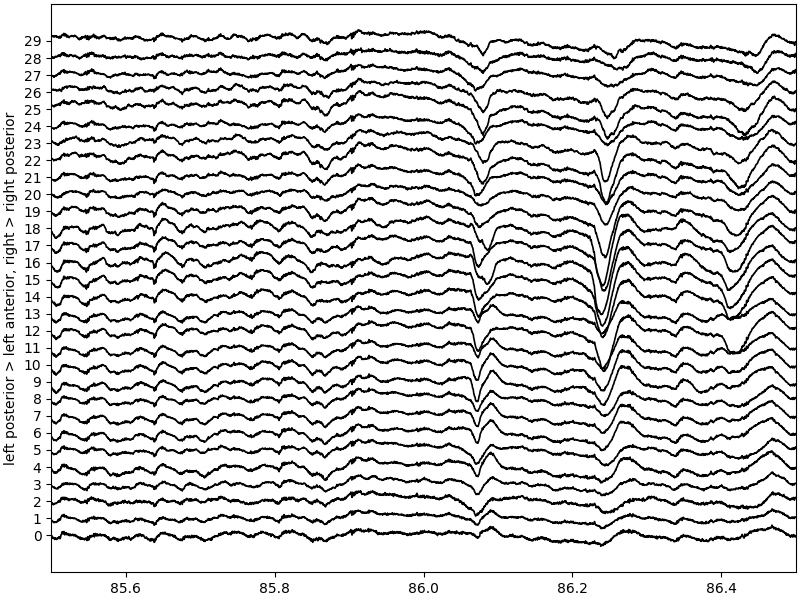

In [88]:
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
sep = 0.5
## Plot EEG ##
eeginds = np.nonzero((eeg_ts > timewin[0]) & (eeg_ts < timewin[1]))[0]
for chi in GOOD_CHS:
    ax.plot(eeg_ts[eeginds], eeg_data[eeginds, chi] + chi*sep, color='k', linewidth=1.2)

ax.set_yticks(GOOD_CHS*sep)
ax.set_yticklabels(GOOD_CHS)
ax.set_xlim(timewin)
ax.set_ylabel('left posterior > left anterior, right > right posterior')
# EEGax.set_xticklabels([])


## Add SWD events ##
plotSWD = autoSWD_df[(autoSWD_df['offset'] > timewin[0]) & (autoSWD_df['onset'] < timewin[1])]
for ii, SWDi in plotSWD.iterrows():
    ax.axvspan(SWDi.onset, SWDi.offset, color='k', alpha=0.1)

### SAVE ###
fig_name = 'EEGchs_example_{:.0f}_{:.0f}s.png'.format(start_time, win_size)
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

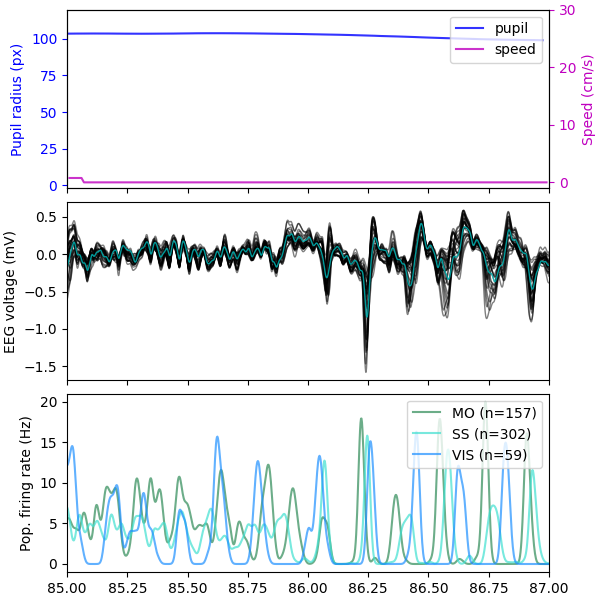

In [73]:
fig, axs = plt.subplots(3, 1, figsize=(6, 6), constrained_layout=True, sharex=True)

legenditems = []
## Pupil ##
pupinds = np.nonzero((pupilts > timewin[0]) & (pupilts < timewin[1]))[0]
pup, = axs[0].plot(pupilts[pupinds], sm_pupil[pupinds], color='b', alpha=0.8, label='pupil')
legenditems.append(pup)
axs[0].set_xlim(timewin)
axs[0].set_ylim([-2, 120])
axs[0].set_ylabel('Pupil radius (px)', color='b')
axs[0].tick_params(axis='y', colors='b')

## Running ##
runax = axs[0].twinx()
runinds = np.nonzero((speedts > timewin[0]) & (speedts < timewin[1]))[0]
run, = runax.plot(speedts[runinds], speed[runinds], color='m', alpha=0.8, label='speed')
legenditems.append(run)
runax.set_ylabel('Speed (cm/s)', color='m')
runax.tick_params(axis='y', colors='m')
runax.set_ylim([-1, 30])
axs[0].legend(handles = legenditems, loc='upper right')

## Plot EEG ##
eeginds = np.nonzero((eeg_ts > timewin[0]) & (eeg_ts < timewin[1]))[0]
axs[1].plot(eeg_ts[eeginds], filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
axs[1].plot(eeg_ts[eeginds], filt_data[eeginds, :][:, 20], color='c', linewidth=1.0, alpha=0.8)
# axs[1].set_xlim(timewin)
axs[1].set_ylabel('EEG voltage (mV)')
# EEGax.set_xticklabels([])

leglabels = []
for regtype in plot_regions.keys():
    for regi, rcol in plot_regions[regtype].items():
        regidf = unit_info[unit_info[regtype] == regi]
        if len(regidf) > 0:
            counts = []
            for uind, unitrow in regidf.iterrows():
                uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
                spcounts, edges = np.histogram(uspikes, spike_bins)
                counts.append(spcounts)
            popfr = np.mean(np.stack(counts), axis=0) / (time_bin)# * len(regidf))
            popSDF = ndimage.gaussian_filter(popfr, sigma=5, output=float)
            axs[2].plot(spike_bins[:-1], popSDF, color=rcol, alpha=0.7)
            leglabels.append('{} (n={:d})'.format(regi, len(regidf)))
axs[2].legend(leglabels, loc='upper right')
axs[2].set_xlim(timewin)
axs[2].set_ylabel('Pop. firing rate (Hz)')

## Add SWD events ##
# plotSWD = autoSWD_df[(autoSWD_df['offset'] > timewin[0]) & (autoSWD_df['onset'] < timewin[1])]
# for ii, SWDi in plotSWD.iterrows():
#     axs[0].axvspan(SWDi.onset, SWDi.offset, color='k', alpha=0.1)
#     axs[1].axvspan(SWDi.onset, SWDi.offset, color='k', alpha=0.1)
#     axs[2].axvspan(SWDi.onset, SWDi.offset, color='k', alpha=0.1)

### SAVE ###
fig_name = 'EEG_popFR_example_{:.0f}_{:.0f}s.png'.format(start_time, win_size)
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

Another window

In [50]:
time_bin = 0.002 # size of time bins (s)
start_time = 300.0 # eeg_ts[0]
win_size = 50.0 # length of time to plot (s)
timewin = [start_time, start_time + win_size]
spike_bins = np.arange(timewin[0], timewin[1], time_bin)

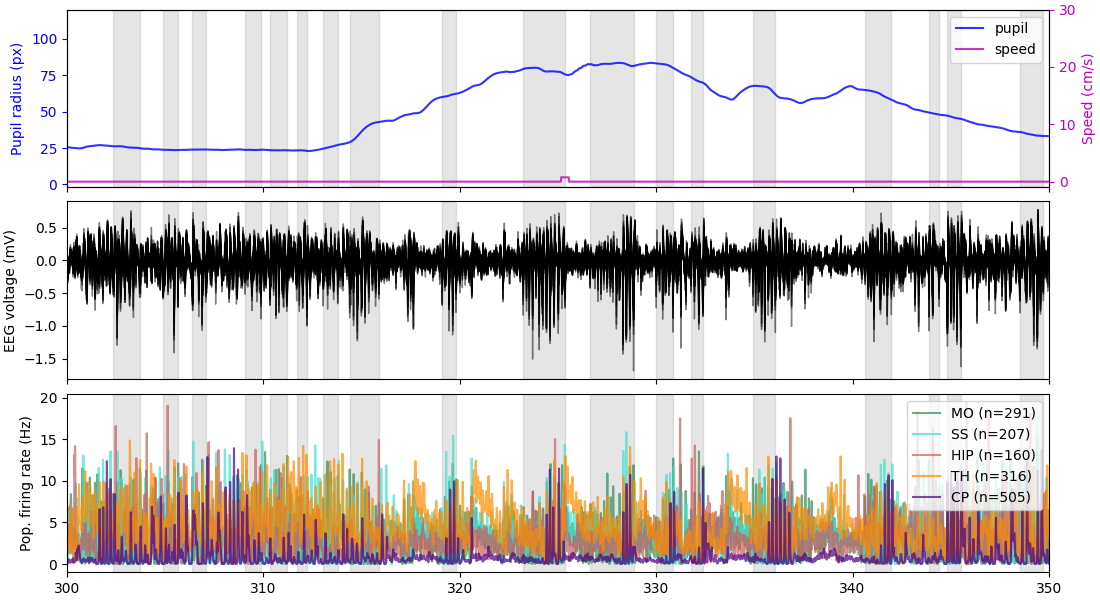

In [51]:
fig, axs = plt.subplots(3, 1, figsize=(11, 6), constrained_layout=True, sharex=True)

legenditems = []
## Pupil ##
pupinds = np.nonzero((pupilts > timewin[0]) & (pupilts < timewin[1]))[0]
pup, = axs[0].plot(pupilts[pupinds], sm_pupil[pupinds], color='b', alpha=0.8, label='pupil')
legenditems.append(pup)
axs[0].set_xlim(timewin)
axs[0].set_ylim([-2, 120])
axs[0].set_ylabel('Pupil radius (px)', color='b')
axs[0].tick_params(axis='y', colors='b')

## Running ##
runax = axs[0].twinx()
runinds = np.nonzero((speedts > timewin[0]) & (speedts < timewin[1]))[0]
run, = runax.plot(speedts[runinds], speed[runinds], color='m', alpha=0.8, label='speed')
legenditems.append(run)
runax.set_ylabel('Speed (cm/s)', color='m')
runax.tick_params(axis='y', colors='m')
runax.set_ylim([-1, 30])
axs[0].legend(handles = legenditems, loc='upper right')

## Plot EEG ##
eeginds = np.nonzero((eeg_ts > timewin[0]) & (eeg_ts < timewin[1]))[0]
axs[1].plot(eeg_ts[eeginds], filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
# axs[1].set_xlim(timewin)
axs[1].set_ylabel('EEG voltage (mV)')
# EEGax.set_xticklabels([])

leglabels = []
for regtype in plot_regions.keys():
    for regi, rcol in plot_regions[regtype].items():
        regidf = unit_info[unit_info[regtype] == regi]
        if len(regidf) > 0:
            counts = []
            for uind, unitrow in regidf.iterrows():
                uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
                spcounts, edges = np.histogram(uspikes, spike_bins)
                counts.append(spcounts)
            popfr = np.mean(np.stack(counts), axis=0) / (time_bin)# * len(regidf))
            popSDF = ndimage.gaussian_filter(popfr, sigma=5, output=float)
            axs[2].plot(spike_bins[:-1], popSDF, color=rcol, alpha=0.7)
            leglabels.append('{} (n={:d})'.format(regi, len(regidf)))
axs[2].legend(leglabels, loc='upper right')
axs[2].set_xlim(timewin)
axs[2].set_ylabel('Pop. firing rate (Hz)')

## Add SWD events ##
plotSWD = autoSWD_df[(autoSWD_df['offset'] > timewin[0]) & (autoSWD_df['onset'] < timewin[1])]
for ii, SWDi in plotSWD.iterrows():
    axs[0].axvspan(SWDi.onset, SWDi.offset, color='k', alpha=0.1)
    axs[1].axvspan(SWDi.onset, SWDi.offset, color='k', alpha=0.1)
    axs[2].axvspan(SWDi.onset, SWDi.offset, color='k', alpha=0.1)

In [ ]:
choose_event = 5
eventrow = simple_log.iloc[choose_event]
print(eventrow)

In [ ]:
plot_regions = {
    # 'LGd-co': 'mediumseagreen',
    'LP': 'deeppink',
    'PO': 'sienna',
    # 'alv': 'coral',
    # 'PF': 'dodgerblue',
}
time_bin = 0.005 # size of time bins (s)
timewin = [-10., 10.]
event_bins = np.arange(eventrow.onset + timewin[0], eventrow.offset + timewin[1], time_bin)
timex = event_bins[:-1] - eventrow.onset
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.axvspan(0, eventrow.duration, color='m', alpha=0.1)
leglabels = []
for regi, rcol in plot_regions.items():
    regidf = unit_info[unit_info['region'] == regi]
    counts = []
    for uind, unitrow in regidf.iterrows():
        uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
        spcounts, edges = np.histogram(uspikes, event_bins)
        counts.append(spcounts)
    popfr = np.mean(np.stack(counts), axis=0) / (time_bin)# * len(regidf))
    popSDF = ndimage.gaussian_filter(popfr, sigma=5, output=float)
    ax.plot(timex, popSDF, color=rcol, alpha=0.8)
    leglabels.append('{} (n={:d})'.format(regi, len(regidf)))
ax.legend(leglabels)
ax.set_xlabel('Time from stim onset (s)')
ax.set_xlim([timewin[0], eventrow.duration + timewin[1]])
ax.set_ylabel('Pop. firing rate (Hz)')

### Spatial interpolation

In [33]:
autoSWD_df[220:240]

,onset,offset,duration,spike_count,SWD_spike_times
220,874.440449,876.029239,1.588790,12,"[874.4404485660772, 874.5728477537233, 874.722..."
221,880.130014,880.932809,0.802795,5,"[880.1300136569488, 880.3104125500859, 880.439..."
222,885.378781,886.407575,1.028794,8,"[885.3787814523942, 885.3895813861296, 885.407..."
223,887.999565,889.590356,1.590790,9,"[887.9995653722051, 888.1767642849762, 888.326..."
224,891.553944,892.703537,1.149593,5,"[891.5539435638168, 891.8687416323288, 892.081..."
225,893.779130,894.327927,0.548797,4,"[893.7791299108724, 893.8059297464381, 894.167..."
226,895.212721,896.226315,1.013594,7,"[895.2127211148714, 895.3483202828836, 895.515..."
227,897.121909,898.773099,1.651190,11,"[897.1219094007777, 897.2351087062274, 897.506..."
228,901.661481,902.474276,0.812795,5,"[901.6614811027295, 901.8994795655993, 902.041..."
229,907.436244,908.194639,0.758395,3,"[907.4362438060116, 907.8042414292727, 908.194..."


In [58]:
## Create the EEG mesh ##
ml = np.linspace(-5, 5, 100)
ap = np.linspace(-5, 3, 100)
ML, AP = np.meshgrid(ml, ap)

In [59]:
SWDind = 220
deltat = 0.5
SWDevent = autoSWD_df.iloc[SWDind]
plot_window = [SWDevent.onset - deltat, SWDevent.offset + deltat]

plot_inds = np.nonzero((eeg_ts > plot_window[0]) & (eeg_ts < plot_window[1]))[0]
frameinds = plot_inds[::20]

ctx_EEG_timeseries = []
for indi in frameinds:
    ctx_EEG_timeseries.append(interpolate.griddata(
        (EEGexp.EEG_channel_coordinates['ML'][GOOD_CHS], EEGexp.EEG_channel_coordinates['AP'][GOOD_CHS]),
        filt_data[indi, :], (ML, AP), method='cubic',
    ))
spatiotempEEG = np.array(ctx_EEG_timeseries)

In [60]:
spatiotempEEG.shape

(324, 100, 100)

Plot and animate

<IPython.core.display.Javascript object>


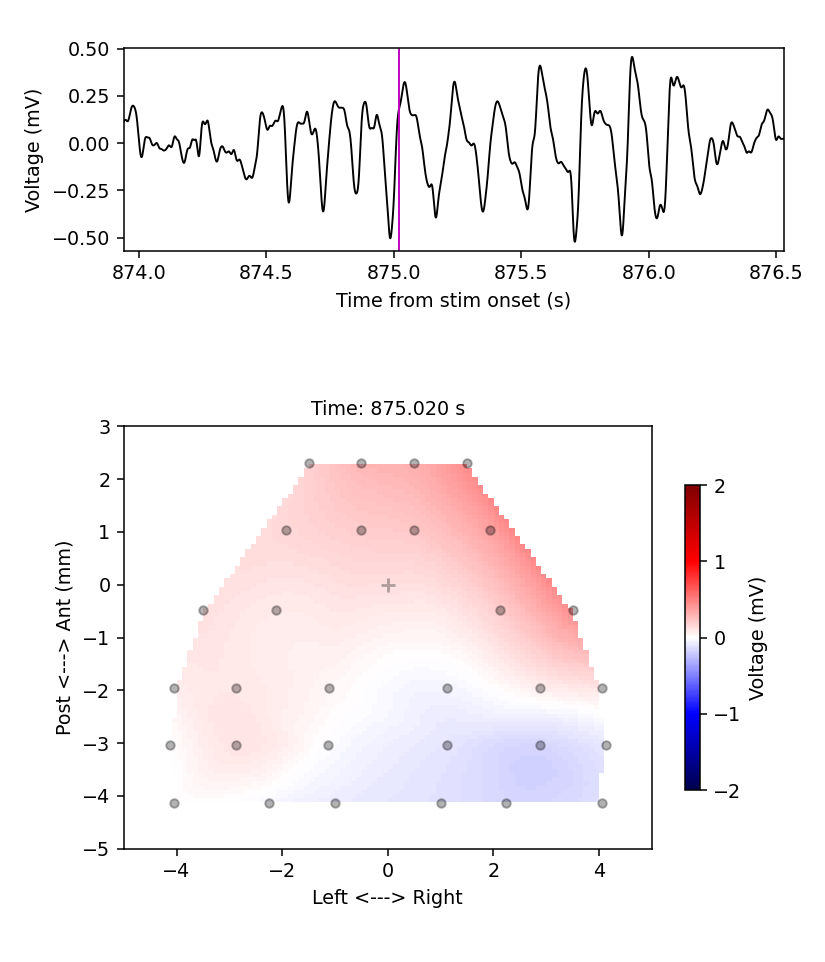

In [68]:
fig = plt.figure(figsize=(6, 7))
gs = fig.add_gridspec(ncols=1, nrows=2, top=0.95, bottom=0.02, left=0.15, right=0.95, hspace=0.2, height_ratios=[1,3])
initframe = 0

## Plot one ch with moving vertical line ##
chax = fig.add_subplot(gs[0])
chax.plot(eeg_ts[plot_inds], filt_data[plot_inds, 13], color='k', linewidth=1)
chline = chax.axvline(x=eeg_ts[frameinds[initframe]], color='m', linewidth=1)
chax.set_xlim(plot_window)
chax.set_xlabel('Time from stim onset (s)')
chax.set_ylabel('Voltage (mV)')

## Plot one ch with moving vertical line ##
hmax = fig.add_subplot(gs[1])
sptp = hmax.imshow(
    spatiotempEEG[0,:,:], cmap='seismic', vmin=-2, vmax=2,
    origin='lower', interpolation='none', extent=(ml[0], ml[-1], ap[0], ap[-1]),
)
hmax.scatter(
    EEGexp.EEG_channel_coordinates['ML'][GOOD_CHS], EEGexp.EEG_channel_coordinates['AP'][GOOD_CHS],
    c='k', alpha=0.3, marker='o', s=20
)
hmax.scatter(0, 0, marker='+', color='k', s=50, alpha=0.3)
hmax.set_aspect('equal')
hmax.set_ylabel('Post <---> Ant (mm)')
hmax.set_xlabel('Left <---> Right')

cb = fig.colorbar(sptp, ax=hmax, shrink=.5, aspect=20)
cb.set_label('Voltage (mV)')
hmax.set_title('Time: {:.3f} s'.format(eeg_ts[frameinds[initframe]]))

## animate function ##
def animate(i):
    chline.set_data([eeg_ts[frameinds[i]], eeg_ts[frameinds[i]]], [0, 1])
    sptp.set_data(spatiotempEEG[i,:,:])
    hmax.set_title('Time: {:.3f} s'.format(eeg_ts[frameinds[i]]))

## animate it ##
anim = animation.FuncAnimation(fig, animate, init_func=None, frames=frameinds.shape[0], interval=80, blit=False)

movie_name = os.path.join(plotsavedir, '{}_spatiotempEEG_{:d}-{:d}s.mp4'.format(exp_tag, int(plot_window[0]), int(plot_window[1])))
# anim.save(movie_name, writer='ffmpeg', fps=12, extra_args=['-vcodec', 'libx264'], dpi=1000, bitrate=-1)
anim.save(movie_name, writer='ffmpeg', fps=6, extra_args=['-vcodec', 'libx264'], dpi=300, bitrate=-1)